In [4]:
import sys
import os
import math
import time
import pathlib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
# There are other models we can use...
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import EfficientNetV2L
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error

# Dataset paths

In [5]:
# Dataset paths
train_dir = pathlib.Path('BrainTumorDataset/Training')
test_dir = pathlib.Path('BrainTumorDataset/Testing')

img_height = 512
img_width = 512
batch_size = 16
epochs = 20

# Data augmentation

In [6]:
# Dataset loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
    shuffle=True,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=batch_size,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 2442 files belonging to 4 classes.
Using 1954 files for training.
Classes in the dataset: ['1', '2', '3', 'notumor']
Found 2442 files belonging to 4 classes.
Using 488 files for validation.
Found 2133 files belonging to 4 classes.


# Balancing using class weights

In [7]:
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

Calculating class weights...
Class weights calculated.


2025-03-03 16:33:35.447282: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=0.0001, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

In [8]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

# Train all models with 30 epochs

In [ ]:
# Define the model(s)
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

In [ ]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

In [ ]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [2]:
import gdown

file_id = "1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx"
output_path = "ResNet152.keras"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx
From (redirected): https://drive.google.com/uc?id=1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx&confirm=t&uuid=38d01b8d-dbcb-4d7a-a9b1-bfd9f8c72d21
To: /Users/ahmedalsunbati/Documents/GitHub/brain-tumor-analysis/ResNet152.keras
100%|██████████| 714M/714M [00:30<00:00, 23.3MB/s] 


'ResNet152.keras'

In [3]:
from tensorflow import keras

model_path = "ResNet152.keras"  # Update the path if needed
model = keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━

2025-03-03 23:26:57.661857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


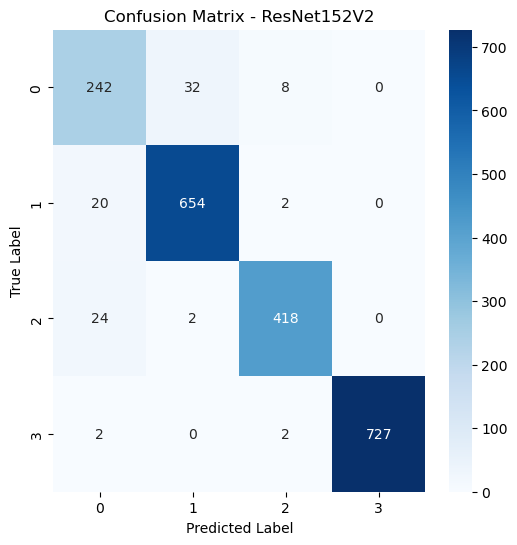

(0.956868260665729,
 0.9574124045544907,
 0.956868260665729,
 0.9570506943718992,
 0.06000937646507267,
 0.09563994374120956,
 array([[242,  32,   8,   0],
        [ 20, 654,   2,   0],
        [ 24,   2, 418,   0],
        [  2,   0,   2, 727]]))

In [10]:
#After training model(s)
evaluate_model(model, test_ds, 'ResNet152V2')